In [96]:
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sps
import seaborn as sns
import xgboost as xgb
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
# read dataset
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

# Data preprocessing and EDA

In [7]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [8]:
# no NaN :)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [3]:
# rename target
rename_dict = {"dep_delayed_15min": "is_delayed"}
train.rename(columns=rename_dict, inplace=True)

In [4]:
# convert date columns to int
for column in ["Month", 'DayofMonth', 'DayOfWeek']:
    train[column] = train[column].str.extract(r'(\d+)')
    test[column] = test[column].str.extract(r'(\d+)')
    train[column] = pd.to_numeric(train[column])
    test[column] = pd.to_numeric(test[column])

In [5]:
# change target class labels to 0/1
train["is_delayed"] = train["is_delayed"].map({"N" : 0, "Y" : 1})

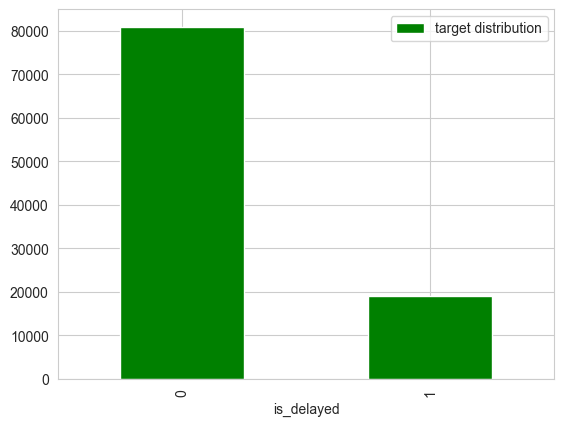

In [6]:
# target class is unbalanced -> Stratified
train["is_delayed"].value_counts().plot(kind="bar", label="target distribution", color="g");
plt.legend();

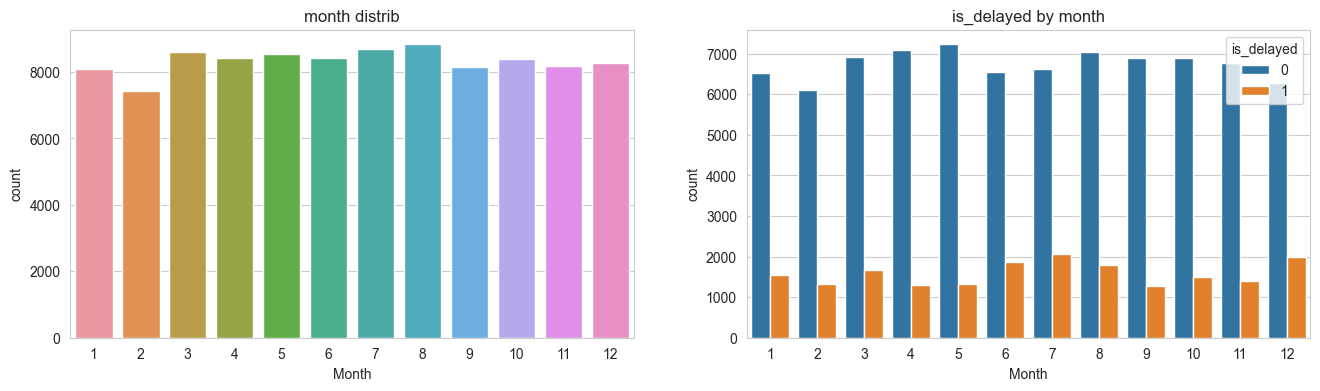

In [35]:
# slightly more delays in summer
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x="Month", ax=ax[0]);
ax[0].set_title("month distrib");
sns.countplot(data=train, x="Month", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by month");

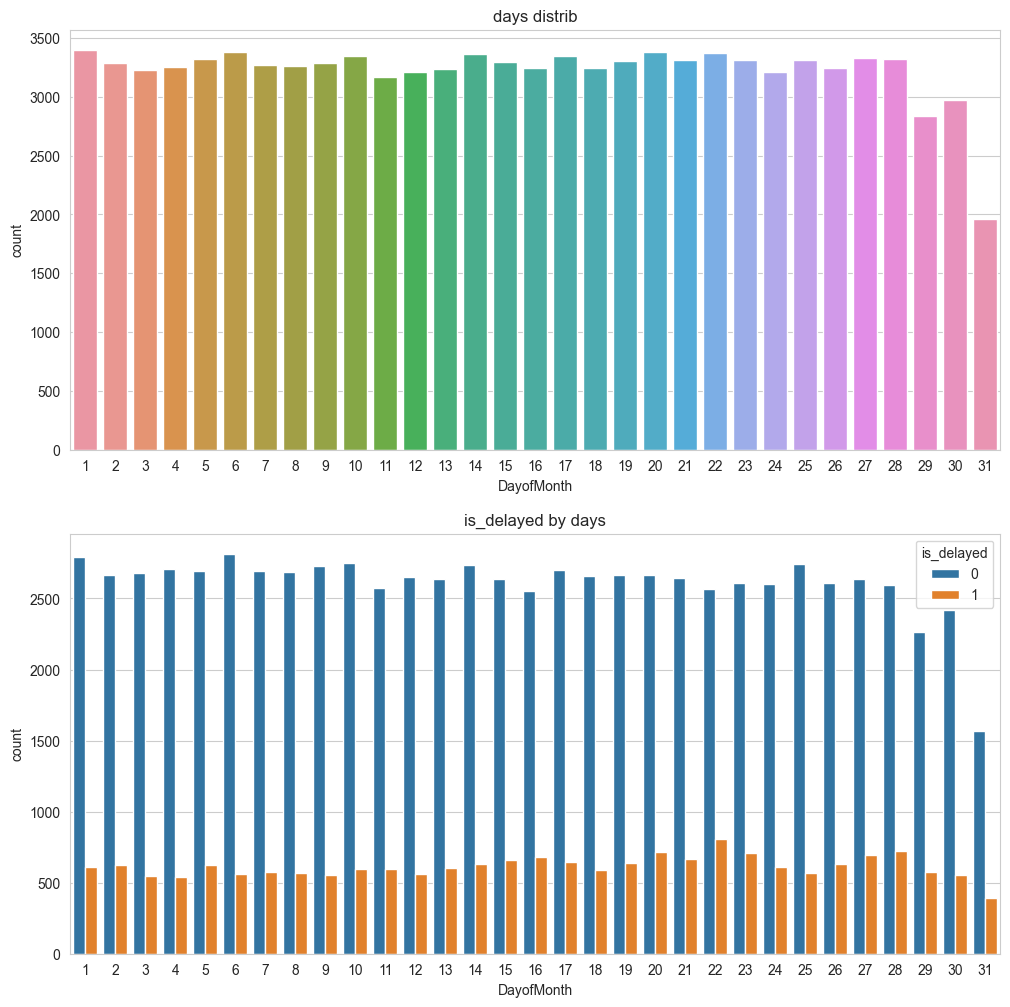

In [7]:
# there only 7 month with 31 day but delay is pretty high
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.countplot(data=train, x="DayofMonth", ax=ax[0]);
ax[0].set_title("days distrib");
sns.countplot(data=train, x="DayofMonth", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by days");

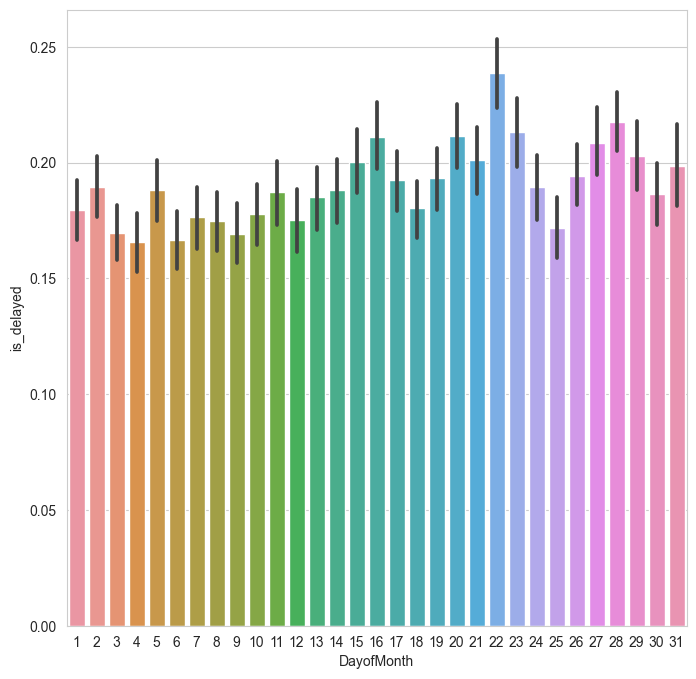

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.barplot(x="DayofMonth", y="is_delayed", data=train, ax=ax);

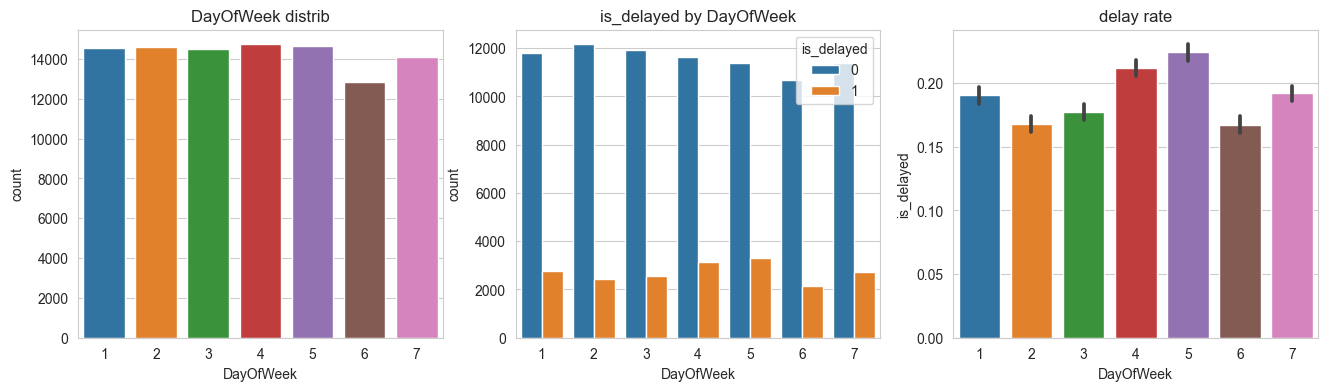

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=train, x="DayOfWeek", ax=ax[0]);
ax[0].set_title("DayOfWeek distrib");
sns.countplot(data=train, x="DayOfWeek", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by DayOfWeek");
sns.barplot(x="DayOfWeek", y="is_delayed", data=train, ax=ax[2]);
ax[2].set_title("delay rate");

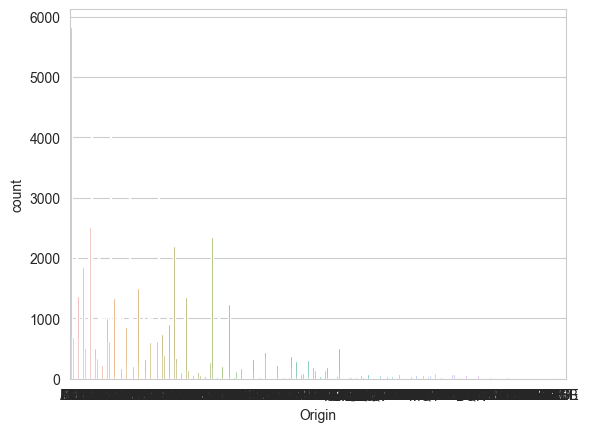

In [8]:
# many origins have a small amount of data
sns.countplot(data=train, x="Origin");

In [12]:
# some origins have 100% delay freq due to lack of data
delay_frequencies = train.groupby('Origin')['is_delayed'].mean()
delay_frequencies.sort_values(ascending=False)

Origin
GST    1.000000
ADK    1.000000
AKN    1.000000
LWB    0.750000
BRW    0.714286
         ...   
PIE    0.000000
LCH    0.000000
ILG    0.000000
SPS    0.000000
PIH    0.000000
Name: is_delayed, Length: 289, dtype: float64

D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


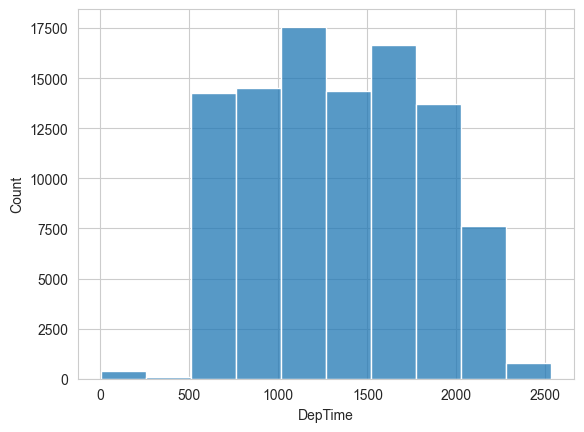

In [20]:
# probably need to parse it to hours, mins etc.
sns.histplot(data=train, x="DepTime", bins=10);

In [9]:
train["DepTime"].describe()

count    100000.000000
mean       1341.523880
std         476.378445
min           1.000000
25%         931.000000
50%        1330.000000
75%        1733.000000
max        2534.000000
Name: DepTime, dtype: float64

Text(0.5, 1.0, 'delay_rate')

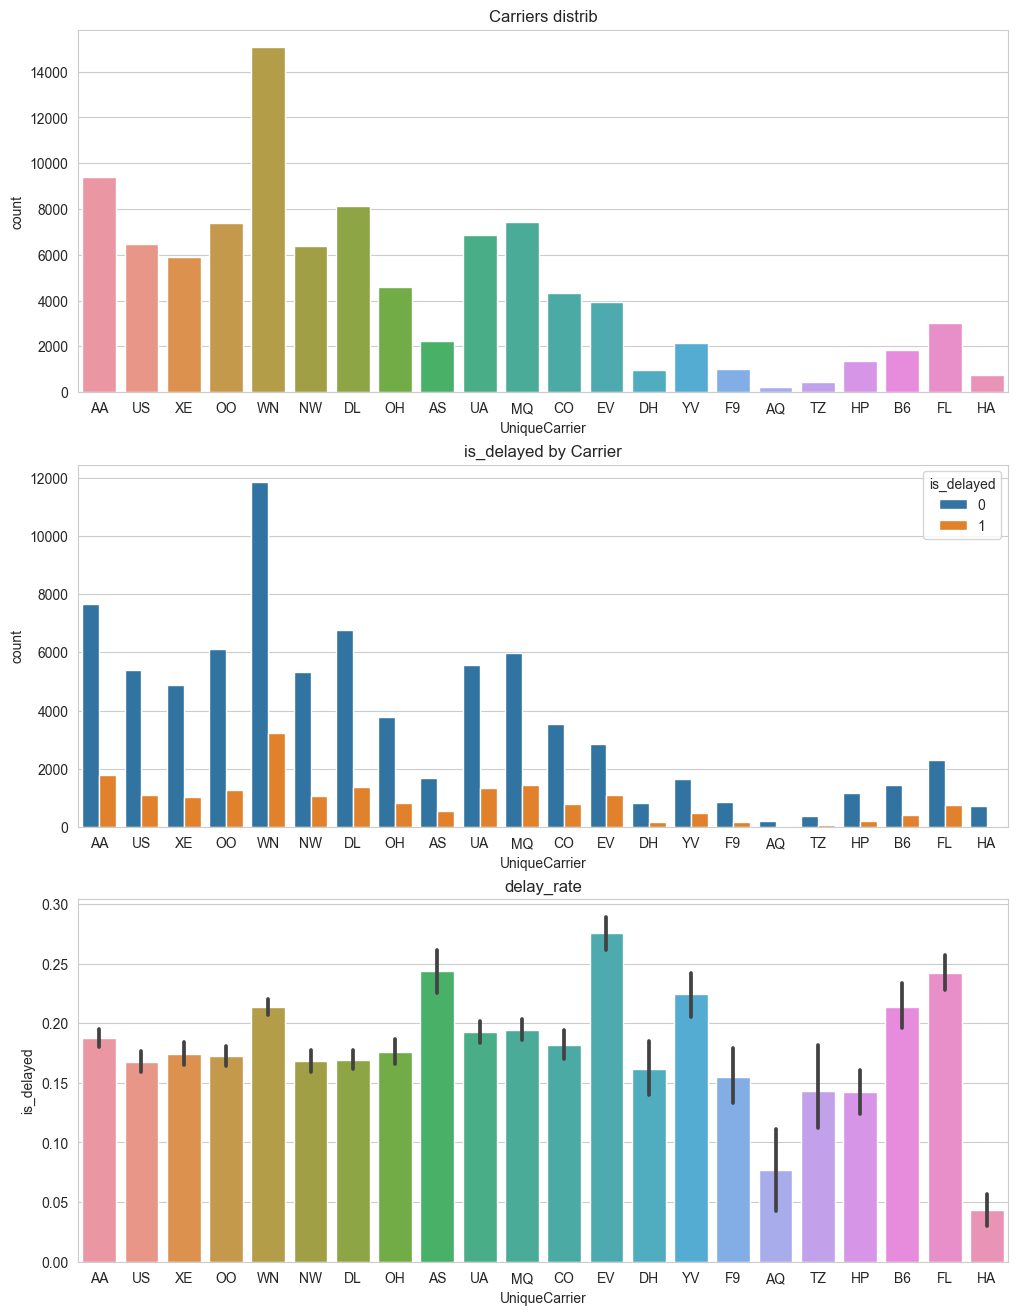

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
sns.countplot(data=train, x="UniqueCarrier", ax=ax[0]);
ax[0].set_title("Carriers distrib");
sns.countplot(data=train, x="UniqueCarrier", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by Carrier")
sns.barplot(data=train, x="UniqueCarrier", y="is_delayed", ax=ax[2], orient="v")
ax[2].set_title("delay_rate")

In [6]:
carrier_categories = train["UniqueCarrier"].value_counts().map(lambda x: "small" if x <= 2000 else "medium" if 2000 < x <= 8000 else "big")
carrier_dict = {"big" : [], "medium" : [], "small" : []}
for carrier in carrier_categories.index.values:
    carrier_dict[carrier_categories[carrier]].append(carrier)
carrier_dict

{'big': ['WN', 'AA', 'DL'],
 'medium': ['MQ',
  'OO',
  'UA',
  'US',
  'NW',
  'XE',
  'OH',
  'CO',
  'EV',
  'FL',
  'AS',
  'YV'],
 'small': ['B6', 'HP', 'F9', 'DH', 'HA', 'TZ', 'AQ']}

In [8]:
# too much to plot
unique_origins_num = train["Origin"].unique().shape[0]
unique_dest_num = train["Dest"].unique().shape[0]
print(f"unique origins: {unique_origins_num}")
print(f"unique dest: {unique_dest_num}")

unique origins: 289
unique dest: 289


D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


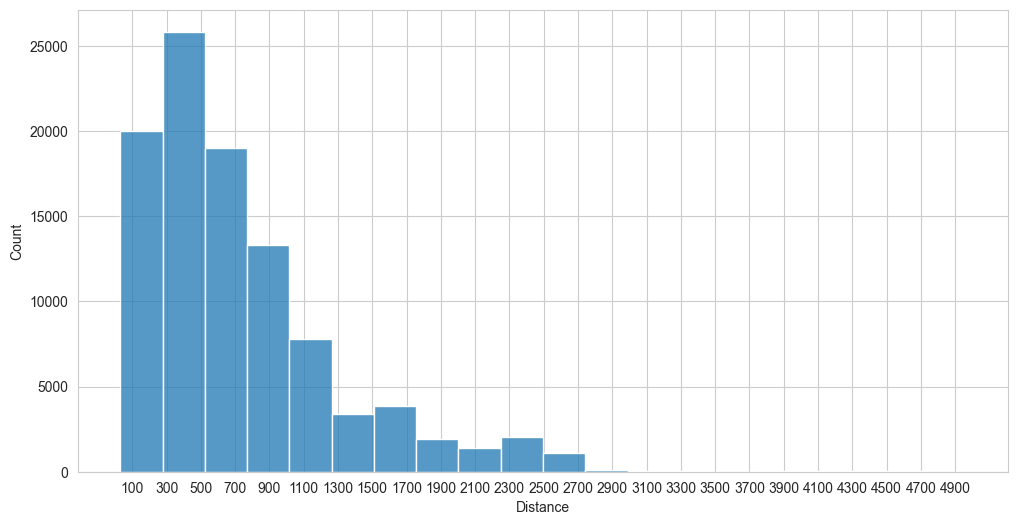

In [9]:
# most flights are short
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(data=train, x="Distance", bins=20);
plt.xticks(np.arange(100, np.max(train["Distance"]), 200));

In [68]:
train["Distance"].describe()

count    100000.00000
mean        729.39716
std         574.61686
min          30.00000
25%         317.00000
50%         575.00000
75%         957.00000
max        4962.00000
Name: Distance, dtype: float64

# Feature engineering

In [7]:
# merge train and test
full_df = pd.concat([train, test], ignore_index=True).copy(deep=True)
full_df[100000:]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,is_delayed
100000,7,25,3,615,YV,MRY,PHX,598,NaN
100001,4,17,2,739,WN,LAS,HOU,1235,NaN
100002,12,2,7,651,MQ,GSP,ORD,577,NaN
100003,3,25,7,1614,WN,BWI,MHT,377,NaN
100004,6,6,3,1505,UA,ORD,STL,258,NaN
...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN
199997,1,30,2,1509,OO,ORD,SGF,438,NaN
199998,1,5,5,804,DL,LGA,ATL,761,NaN


In [8]:
# count num of rows by each Origin
num_of_rows = train.groupby('Origin')['is_delayed'].count() / train.shape[0]
full_df['Num_Of_Rows_by_Origin'] = full_df['Origin'].map(num_of_rows)
# Route = Origin + Dest
full_df["Route"] = full_df["Origin"] + "_" + full_df["Dest"]
# parse time
full_df["DepHour"] = full_df["DepTime"].map(lambda x: (x // 100) % 24)
full_df["DepMinute"] = full_df["DepTime"].map(lambda x: x % 100)
full_df["TimeOfDay"] = full_df["DepHour"].map(lambda x: "morning" if 6 <= x < 12 else
                                                        "afternoon" if 12 <= x < 18 else
                                                        "evening" if 18 <= x <= 23 else
                                                        "night")
# categories for distance
full_df["DistCategory"] = full_df["Distance"].map(lambda x: "very_short" if x <= 700 else
                                                            "short" if 500 < x <= 1200 else
                                                            "medium" if 1200 < x <= 2700 else
                                                            "long")
# carries features
full_df["Carrier_Origin"] = full_df["UniqueCarrier"] + "_" + full_df["Origin"]
full_df["Carrier_hour"] = full_df["UniqueCarrier"] + "_" + full_df["DepHour"].astype(str)
full_df["Carrier_size"] = full_df["UniqueCarrier"].map(lambda x: "big" if x in carrier_dict["big"] else
                                                                "small" if x in carrier_dict["small"] else
                                                                "medium")
full_df["Carrier_DayOfMonth"] = full_df["UniqueCarrier"] + "_" + full_df["DayofMonth"].astype(str)
full_df["Carrier_DistCategory"] = full_df["UniqueCarrier"] + "_" + full_df["DistCategory"]
# weekends and higher delay rate
# full_df["Weekend"] = full_df["DayOfWeek"].map(lambda x: "Yes" if x in (6, 7) else "No")
full_df["Higher_Delay_Rate_by_DayOfWeek"] = full_df["DayOfWeek"].map(lambda x: "Yes" if x in [4, 5] else "No")
# seasons
full_df["Season"] = full_df["Month"].map(lambda x: "winter" if x in (12, 1, 2) else
                                                    "spring" if x in (3, 4, 5) else
                                                    "summer" if x in (6, 7, 8) else
                                                    "autumn")
full_df["Hour_Season"] = full_df["DepHour"].astype(str) + "_" + full_df["Season"]
full_df["Hour_Origin"] = full_df["DepHour"].astype(str) + full_df["Origin"]
# full_df["Hour_Dest"] = full_df["DepHour"].astype(str) +  full_df["Dest"]
full_df["Season_TimeOfDay"] = full_df["Season"] + "_" + full_df["TimeOfDay"]
full_df["Season_Carrier"] = full_df["Season"] + "_" + full_df["UniqueCarrier"]
# drop some features
# full_df.drop(columns=['DepTime'], inplace=True)
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,is_delayed,Num_Of_Rows_by_Origin,...,Carrier_hour,Carrier_size,Carrier_DayOfMonth,Carrier_DistCategory,Higher_Delay_Rate_by_DayOfWeek,Season,Hour_Season,Hour_Origin,Season_TimeOfDay,Season_Carrier
0,8,21,7,1934,AA,ATL,DFW,732,0.0,0.05834,...,AA_19,big,AA_21,AA_short,No,summer,19_summer,19ATL,summer_evening,summer_AA
1,4,20,3,1548,US,PIT,MCO,834,0.0,0.00688,...,US_15,medium,US_20,US_short,No,spring,15_spring,15PIT,spring_afternoon,spring_US
2,9,2,5,1422,XE,RDU,CLE,416,0.0,0.00868,...,XE_14,medium,XE_2,XE_very_short,Yes,autumn,14_autumn,14RDU,autumn_afternoon,autumn_XE
3,11,25,6,1015,OO,DEN,MEM,872,0.0,0.02973,...,OO_10,medium,OO_25,OO_short,No,autumn,10_autumn,10DEN,autumn_morning,autumn_OO
4,10,7,6,1828,WN,MDW,OMA,423,1.0,0.01366,...,WN_18,big,WN_7,WN_very_short,No,autumn,18_autumn,18MDW,autumn_evening,autumn_WN


In [9]:
train_new = full_df.iloc[:100000].copy(deep=True)
test_new = full_df.iloc[100000:].copy(deep=True)
test_new.drop(["is_delayed"], axis=1, inplace=True)

X_train, y_train = train_new.drop(["is_delayed"], axis=1), train_new["is_delayed"]

# categorical and numerical features
cat_features = list(X_train.columns[X_train.dtypes == "object"])
print(f"Cat_features: {cat_features}")
num_features = list(X_train.columns[X_train.dtypes != "object"])
print(f"Num_features: {num_features}")

Cat_features: ['UniqueCarrier', 'Origin', 'Dest', 'Route', 'TimeOfDay', 'DistCategory', 'Carrier_Origin', 'Carrier_hour', 'Carrier_size', 'Carrier_DayOfMonth', 'Carrier_DistCategory', 'Higher_Delay_Rate_by_DayOfWeek', 'Season', 'Hour_Season', 'Hour_Origin', 'Season_TimeOfDay', 'Season_Carrier']
Num_features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'Num_Of_Rows_by_Origin', 'DepHour', 'DepMinute']


# Feature importance

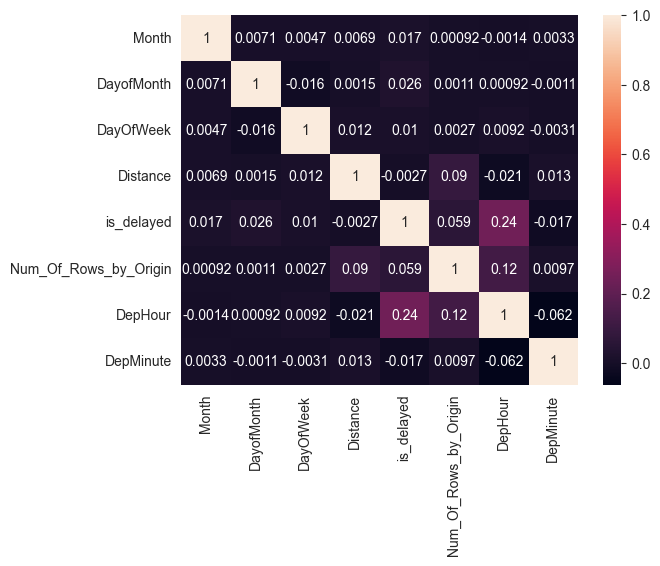

In [37]:
corr = train_new.corr(numeric_only=True)
sns.heatmap(corr, annot=True);

In [56]:
# train and test split
X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, shuffle=True, random_state=22)

In [149]:
# higher weight for delayed
counts = y_train.value_counts()
class_weights = [1, counts[0]/counts[1]]

In [150]:
cat_features_idx = np.where(X_train_part.dtypes == "object")[0]
print(cat_features_idx)

[ 4  5  6  9 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [151]:
# catboost params
params = dict(
    depth=8,
    l2_leaf_reg=0.5,
    bagging_temperature=2.0,
    border_count=64,
    grow_policy='Lossguide',
    num_leaves=10,
    class_weights=class_weights,
    eval_metric='AUC',
    task_type='GPU',
    loss_function='Logloss')

In [152]:
trn_pool = cb.Pool(X_train_part, y_train_part, cat_features=cat_features_idx)
val_pool = cb.Pool(X_valid_part, y_valid_part, cat_features=cat_features_idx)

model = cb.train(params=params,
                 dtrain=trn_pool,
                 verbose=100,
                 early_stopping_rounds=200,
                 eval_set=val_pool,
                 iterations=3600)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6956199	best: 0.6956199 (0)	total: 14.4ms	remaining: 51.9s
100:	test: 0.7231841	best: 0.7231841 (100)	total: 1.28s	remaining: 44.5s
200:	test: 0.7298883	best: 0.7298883 (200)	total: 2.55s	remaining: 43.2s
300:	test: 0.7328395	best: 0.7328395 (300)	total: 3.81s	remaining: 41.8s
400:	test: 0.7349184	best: 0.7349184 (400)	total: 5.05s	remaining: 40.3s
500:	test: 0.7365749	best: 0.7365749 (500)	total: 6.36s	remaining: 39.3s
600:	test: 0.7377555	best: 0.7377555 (600)	total: 7.7s	remaining: 38.4s
700:	test: 0.7386345	best: 0.7386345 (700)	total: 8.97s	remaining: 37.1s
800:	test: 0.7395068	best: 0.7395068 (800)	total: 10.2s	remaining: 35.8s
900:	test: 0.7402337	best: 0.7402487 (896)	total: 11.5s	remaining: 34.5s
1000:	test: 0.7408132	best: 0.7408132 (1000)	total: 12.8s	remaining: 33.3s
1100:	test: 0.7415317	best: 0.7415372 (1099)	total: 14.1s	remaining: 31.9s
1200:	test: 0.7421603	best: 0.7421603 (1200)	total: 15.3s	remaining: 30.5s
1300:	test: 0.7427174	best: 0.7427266 (1295)	tota

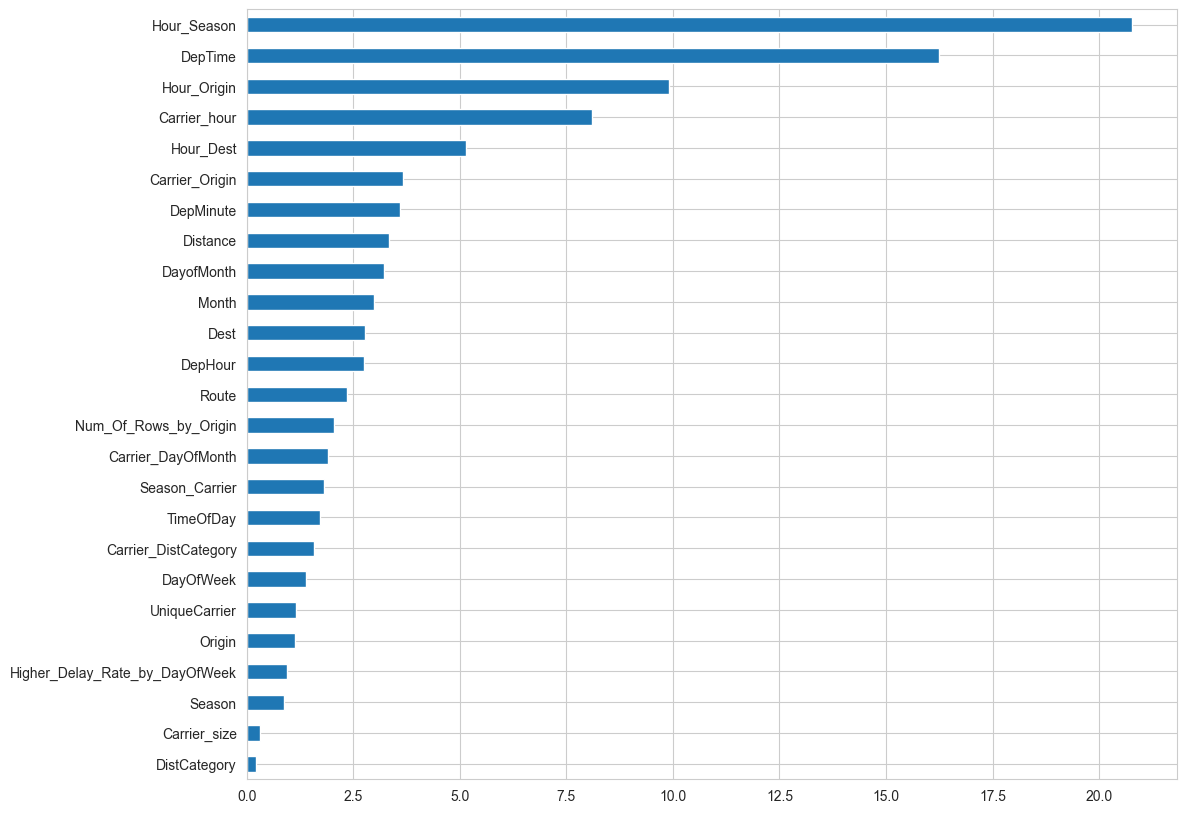

In [153]:
# plot feature importance
def feature_importance(model):
    scores = model.feature_importances_
    indices = [c for c in model.feature_names_]
    ser = pd.Series(dict(zip(indices, scores)))
    ser.sort_values(inplace=True)
    return ser

def plot_feature_importance(model):
    fig, ax = plt.subplots(figsize=(12, 10))
    importance = feature_importance(model)
    importance.plot.barh(ax=ax)

plot_feature_importance(model)

# Modeling

In [97]:
# Pipelines for automatic preprocessing

# Standard scaler for numerical features
std_scaler = StandardScaler()
imputer_num = SimpleImputer(strategy="median")
pipe_num = Pipeline([("imputer", imputer_num), ("scaler", std_scaler)])

# OHE for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
imputer_cat = SimpleImputer(strategy="most_frequent")
pipe_cat = Pipeline([("imputer", imputer_cat), ("encoder", one_hot_encoder)])
col_transformer = ColumnTransformer([("num", pipe_num, [feature for feature in num_features]),
                                     ("cat", pipe_cat, cat_features)], remainder="passthrough")

In [98]:
# X_train after transforming
X_train_transformed = col_transformer.fit_transform(X_train)
X_train_transformed[:5]

<5x12058 sparse matrix of type '<class 'numpy.float64'>'
	with 125 stored elements in Compressed Sparse Row format>

In [41]:
# # to show new features set param "sparse_output=False" at OHE and use this:
# X_train_transformed = pd.DataFrame(X_train_transformed, columns= [col.split("__")[-1] for col in col_transformer.get_feature_names_out()])
# X_train_transformed.head()

In [99]:
X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train_transformed, y_train, test_size=0.3, stratify=y_train, shuffle=True)

## Tuning with HyperOpt

In [175]:
def score(params):
    print("Params:", params)
    rounds = 2500
    dtrain = xgb.DMatrix(X_train_part, y_train_part)
    dvalid = xgb.DMatrix(X_valid_part, y_valid_part)
    watchlist = [(dtrain, "train"), (dvalid, "valid")]
    eval_result = {}
    model = xgb.train(params,
                      dtrain,
                      num_boost_round=rounds,
                      early_stopping_rounds=100,
                      evals=watchlist,
                      evals_result=eval_result,
                      verbose_eval=False)
    best_iteration = model.best_iteration
    score = eval_result["valid"]["auc"][best_iteration]
    print(f"Score: {score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize(trials, space, max_evals=10):
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

In [41]:
trials = Trials()

In [177]:
# space for optimization
space = {
    "learning_rate": hp.quniform("eta", 0.001, 0.05, 0.001),
    "max_depth": hp.choice("max_depth", np.arange(7, 14, dtype=int)),
    # "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "min_child_weight": 1,
    "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
    "gamma": hp.quniform("gamma", 0.6, 1, 0.01), # min loss reduction
    "colsample_bytree": hp.quniform("colsample_bytree", 0.65, 0.85, 0.05),
    "alpha": hp.quniform("alpha", 1, 5, 0.1),  # L1
    "lambda": hp.quniform("lambda", 3, 10, 0.1),  # L2
    "eval_metric": "auc",
    "objective": "binary:logistic",
    'device': 'cuda'
}

best_params = optimize(trials, space, 40)
best_params

Params:                                               
{'alpha': 3.1, 'colsample_bytree': 0.65, 'device': 'cuda', 'eval_metric': 'auc', 'gamma': 0.75, 'lambda': 7.0, 'learning_rate': 0.006, 'max_depth': 10, 'min_child_weight': 1, 'objective': 'binary:logistic', 'subsample': 0.75}
Score: 0.7505671302703462                             
Params:                                                                             
{'alpha': 2.5, 'colsample_bytree': 0.8500000000000001, 'device': 'cuda', 'eval_metric': 'auc', 'gamma': 0.91, 'lambda': 6.7, 'learning_rate': 0.014, 'max_depth': 9, 'min_child_weight': 1, 'objective': 'binary:logistic', 'subsample': 0.7000000000000001}
Score: 0.7533864628949839                                                           
Params:                                                                             
{'alpha': 4.5, 'colsample_bytree': 0.7000000000000001, 'device': 'cuda', 'eval_metric': 'auc', 'gamma': 0.65, 'lambda': 9.0, 'learning_rate': 0.004, 'max_de

{'alpha': 1.8,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.038,
 'gamma': 0.6,
 'lambda': 5.5,
 'max_depth': 5,
 'subsample': 0.9}

In [100]:
# best params after tuning
xgb_best = {
    'colsample_bytree': 0.85,
    'gamma': 0.76,
    'max_depth': 10,
    'min_child_weight': 1.0,
    'subsample': 0.90,
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.022,
    'device': 'cuda',
    'lambda' : 7.0, # L2
    'alpha' : 1.5, # L1
}

In [101]:
dtrain = xgb.DMatrix(X_train_part, y_train_part)
dvalid = xgb.DMatrix(X_valid_part, y_valid_part)
watchlist = [(dtrain, "train"), (dvalid, "valid")]
eval_result = {}
boost_train = xgb.train(xgb_best, dtrain, num_boost_round=8000, evals_result=eval_result, evals=watchlist, early_stopping_rounds=100)

[0]	train-auc:0.72673	valid-auc:0.70496
[1]	train-auc:0.73913	valid-auc:0.71272
[2]	train-auc:0.74608	valid-auc:0.71830
[3]	train-auc:0.75080	valid-auc:0.72013
[4]	train-auc:0.75387	valid-auc:0.72153
[5]	train-auc:0.75623	valid-auc:0.72345
[6]	train-auc:0.75752	valid-auc:0.72479
[7]	train-auc:0.75845	valid-auc:0.72511
[8]	train-auc:0.75870	valid-auc:0.72597
[9]	train-auc:0.75920	valid-auc:0.72663
[10]	train-auc:0.75954	valid-auc:0.72680
[11]	train-auc:0.75969	valid-auc:0.72678
[12]	train-auc:0.76001	valid-auc:0.72714
[13]	train-auc:0.75993	valid-auc:0.72718
[14]	train-auc:0.76088	valid-auc:0.72772
[15]	train-auc:0.76173	valid-auc:0.72806
[16]	train-auc:0.76237	valid-auc:0.72824
[17]	train-auc:0.76274	valid-auc:0.72869
[18]	train-auc:0.76293	valid-auc:0.72870
[19]	train-auc:0.76358	valid-auc:0.72906
[20]	train-auc:0.76384	valid-auc:0.72935
[21]	train-auc:0.76416	valid-auc:0.72972
[22]	train-auc:0.76482	valid-auc:0.73022
[23]	train-auc:0.76568	valid-auc:0.73044
[24]	train-auc:0.76609	val

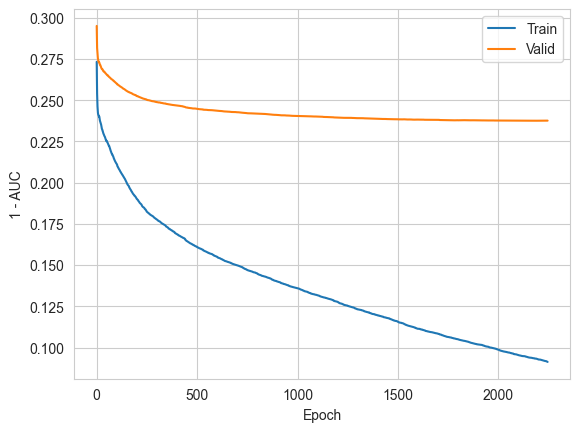

In [113]:
epochs = range(0, len(eval_result["train"]["auc"]))
plt.plot(epochs, [1 - auc for auc in eval_result['train']['auc']], label="Train")
plt.plot(epochs, [1 - auc for auc in eval_result['valid']['auc']], label="Valid")
plt.xlabel('Epoch')
plt.ylabel('1 - AUC')
plt.legend()
plt.show()

In [124]:
# train with all data
dtrain = xgb.DMatrix(X_train_transformed, y_train)
watchlist = [(dtrain, "train")]
boost = xgb.train(xgb_best, dtrain, 2400, evals=watchlist)

[0]	train-auc:0.73215
[1]	train-auc:0.74375
[2]	train-auc:0.74595
[3]	train-auc:0.74828
[4]	train-auc:0.74961
[5]	train-auc:0.74977
[6]	train-auc:0.75047
[7]	train-auc:0.75159
[8]	train-auc:0.75204
[9]	train-auc:0.75206
[10]	train-auc:0.75292
[11]	train-auc:0.75345
[12]	train-auc:0.75442
[13]	train-auc:0.75495
[14]	train-auc:0.75536
[15]	train-auc:0.75619
[16]	train-auc:0.75649
[17]	train-auc:0.75707
[18]	train-auc:0.75730
[19]	train-auc:0.75789
[20]	train-auc:0.75819
[21]	train-auc:0.75847
[22]	train-auc:0.75910
[23]	train-auc:0.75955
[24]	train-auc:0.75998
[25]	train-auc:0.76053
[26]	train-auc:0.76122
[27]	train-auc:0.76182
[28]	train-auc:0.76209
[29]	train-auc:0.76248
[30]	train-auc:0.76287
[31]	train-auc:0.76321
[32]	train-auc:0.76377
[33]	train-auc:0.76414
[34]	train-auc:0.76450
[35]	train-auc:0.76465
[36]	train-auc:0.76508
[37]	train-auc:0.76516
[38]	train-auc:0.76532
[39]	train-auc:0.76581
[40]	train-auc:0.76601
[41]	train-auc:0.76620
[42]	train-auc:0.76669
[43]	train-auc:0.7673

In [125]:
boost.save_model('xgb_model_final.bin')

D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:56:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [126]:
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_model_final.bin')

In [121]:
# Try on test data
test_transformed = col_transformer.transform(test_new)
dtest = xgb.DMatrix(test_transformed)

In [122]:
pred = boost.predict(dtest)

In [123]:
# for kaggle competition
pd.Series(pred, name="dep_delayed_15min").to_csv(
    "kaggle_submission_xgb_final.csv", index_label="id", header=True
)

# Linear model

In [20]:
space_logit = {
    "penalty" : hp.choice("penalty", ["l1", "l2"]),
    "C" : hp.loguniform("C", -5 * np.log(10), 0),
    "class_weight" : hp.choice("class_weight", ["balanced", None]),
    "solver" : "liblinear"
}

In [21]:
def score_logit(params):
    print("Params: ", params)
    lin_model = LogisticRegression(**params)
    lin_model.fit(X_train_part, y_train_part)
    pred = lin_model.predict_proba(X_valid_part)[:, 1]
    score = roc_auc_score(y_valid_part, pred)
    print(f"Score:{score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize_logit(trials, space, max_evals=10):
    best = fmin(score_logit, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

In [22]:
trials = Trials()

In [24]:
optimize_logit(trials, space_logit, 50)

Params:                                                
{'C': 0.005072443871739526, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Score:0.6959442660533482                               
Params:                                                                           
{'C': 0.7913284164626679, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Score:0.7243087182160763                                                          
Params:                                                                           
{'C': 0.0037139253020295137, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Score:0.6947587808895739                                                          
Params:                                                                           
{'C': 0.9844564317247443, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Score:0.7206879175351819                                                          
Params:                          

{'C': 0.24619330755893312, 'class_weight': 1, 'penalty': 0}

In [102]:
best_logit_params = {
    'C': 0.25,
    'penalty': "l1",
    'class_weight': 'balanced',
    'solver' : 'liblinear'
}

In [127]:
logit = LogisticRegression(**best_logit_params)
logit.fit(X_train_part, y_train_part)

LogisticRegression(C=0.25, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [104]:
boost

In [105]:
logit_pred = logit.predict_proba(X_valid_part)[:, 1]
boost_pred = boost.predict(dvalid)

In [109]:
weight = 0.985
final_pred = logit_pred * (1 - weight) + boost_pred * weight
roc_auc_score(y_valid_part, final_pred)

0.7623823607522134

let's take the weighted answer of the two models and put it all together into one model

In [86]:
from sklearn.base import BaseEstimator

class My_Model(BaseEstimator):
    def __init__(self, w=None, logit_params=None, xgb_params=None):
        self.logit = None
        self.boost = None
        self.w = w
        self.logit_params = logit_params
        self.xgb_params = xgb_params

    def get_params(self, deep=True):
        return {"w": self.w, "logit_params" : self.logit_params, "xgb_params" : self.xgb_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X: np.array, y: np.array):
        train = sps.csr_matrix(X)
        dtrain = xgb.DMatrix(train, y)
        self.boost = xgb.train(self.xgb_params, dtrain, 2400)
        self.logit = LogisticRegression(**self.logit_params).fit(train, y)
        return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        boost_pred = self.boost.predict(dtest)
        logit_pred = self.logit.predict_proba(X)[:, 1]
        return self.w * boost_pred + (1 - self.w) * logit_pred

In [87]:
mm = My_Model(0.985, best_logit_params, xgb_best)

In [88]:
mm.fit(X_train_transformed, y_train)

My_Model(logit_params={'C': 0.25, 'class_weight': 'balanced', 'penalty': 'l1',
                       'solver': 'liblinear'},
         w=0.985,
         xgb_params={'alpha': 1.5, 'colsample_bytree': 0.85, 'device': 'cuda',
                     'eval_metric': 'auc', 'gamma': 0.76, 'lambda': 7.0,
                     'learning_rate': 0.022, 'max_depth': 10,
                     'min_child_weight': 1.0, 'objective': 'binary:logistic',
                     'subsample': 0.9})

In [111]:
my_model_test_pred = mm.predict(test_transformed)

In [135]:
pd.Series(my_model_test_pred, name="dep_delayed_15min").to_csv(
    "kaggle_submission.csv", index_label="id", header=True
)